<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W1D1_ModelTypes/W1D1_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  NMA Model Types Tutorial 3: "Why" models

In this tutorial we will explore models and techniques that can potentially explain *why* the spiking data we have observed is produced the way it is.

Tutorial objectives:

- Write code to compute formula for entropy, a measure of information
- Compute the entropy of a number of toy distributions
- Compute the entropy of spiking activity from the Steinmetz dataset

Video available at https://youtube.com/watch?v=fxbBJu258oE


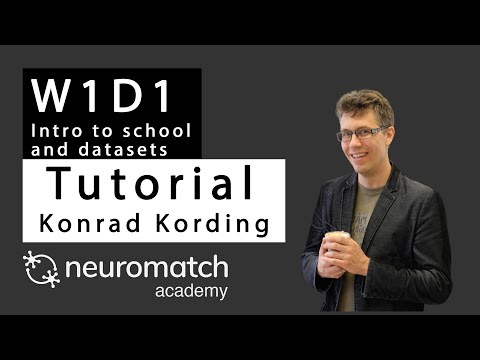

In [1]:
#@title Video: “Why” models
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='fxbBJu258oE', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


## Setup

In [2]:
#@title Imports
import io

import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy.stats as stats

import ipywidgets as widgets

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

%matplotlib inline

In [3]:
#@title Helper Functions
def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins.

  TODO:
    * Passing the mean directly, but could estimate from the counts and bins.
  """
  if ax is None:
    _, ax = plt.subplots()
    
  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, 0, ymax, colors='r', linestyles='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None: 
    ymax = np.max(counts)

  if ax_args.get('yscale', 'linear') == 'log':
    ymax *= 1.5
  else:
    ymax *= 1.1
    if ymin is None:
      ymin = 0
  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=True, axis='x', tight=True)


def eventplot(event_times, colos='k', ax=None, ax_args=None, **kwargs):
  if ax is None:
    _, ax = plt.subplots()

  p = ax.eventplot(event_times, colors='k', **kwargs)

  if ax_args is None:
    ax_args = {}
  
  # `eventplot` behaves differently with a single series? just blank the y-axis for now  
  if len(p) == 1:
    ax.yaxis.set_visible(False)

  ax.set(**ax_args)
  ax.autoscale(enable=True, axis='x', tight=True)

In [4]:
#@title Download Data
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
    print('oops')
steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

## Optimization and Information

Neurons can only fire so often in a fixed period of time, as the act of emitting a spike consumes energy that is depleted and must eventually be replenished. To communicate effectively for downstream computation, the neuron would need to make good use of its limited spiking capability. This becomes an optimization problem: 

What is the optimal way for a neuron to fire in order to maximize its ability to communicate information?

In order to explore this question, we first need to have a quantifiable measure for information. Shannon intoduced the concept of entropy to do just that, and defined it as

\begin{align}
  H_b(X) &= -\sum_{x\in X} p(x) \log_b p(x)
\end{align}

where $H$ is entropy measured in units of base $b$ and $p(x)$ is the probability of observing the event $x$ from the set of all possible events in $X$. See the Appendix for a more detailed look at how this equation was derived.

The most common base of measuring entropy is $b=2$, so we often talk about *bits* of information, though other bases are used as well e.g. when $b=e$ we call the units *nats*.

First, let's explore how entropy changes between some simple discrete probability distributions. In the rest of this tutorial we will refer to these as probability mass functions (PMF), where $p(x_i)$ equals the $i^{th}$ value in an array, and mass refers to how much of the distribution is contained at that value.

For our first PMF, we will choose one where all of the probability mass is located in the middle of the distribution.

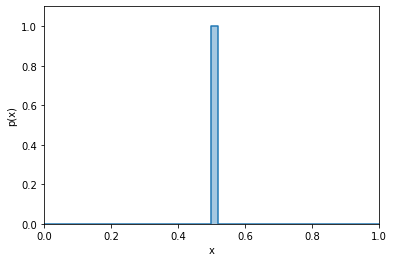

In [5]:
n_points = 50  # points supporting the distribution
bins = np.linspace(0, 1, n_points + 1)

pmf = np.zeros(n_points)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass
# Note: the middle point of `p` maps to the middle bin of `bins` because of shared indexing

histogram(pmf, bins, ax_args={
  'xlabel': "x",
  'ylabel': "p(x)",
  'xlim': [0, None],
})

If we were to draw a sample from this distribution, we know exactly what we would get every time. Distributions where all the mass is concentrated on a single event are known as *deterministic*.

How much entropy is contained in a deterministic distribution?

### Exercise: Computing Entropy

Your first exercise it to implement a method that computes the entropy of a discrete probability mass function. Remember that we are interested in bits, so be sure to use the correct log function. Also recall that $log(0)$ is undefined and will produce a `nan` (Not a Number) value if evaluated.

In [6]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.
  
  This is a measure of information in the distribution. For a totally 
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is, 
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """
  ###############################################################
  ## TODO for students: compute the entropy of the provided PMF #
  ###############################################################
  raise NotImplementedError("Student excercise: implement the equation for entropy")

# Uncomment once the entropy function is complete
# print(f"{entropy(pmf):.2f} bits")

In [7]:
# to_remove solution
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.
  
  This is a measure of information in the distribution. For a totally 
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is, 
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  """
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)

print(f"{entropy(pmf):.2f} bits")

0.00 bits


We expect zero surprise from a deterministic distribution. If we had done this calculation by hand, it would simply be

$-1\log_2 1 = 0$

Note that changing the location of the peak (i.e. the point and bin on which all the mass rests) doesn't alter the entropy. The entropy is about how predictable a sample is with respect to a distribution. A single peak is deterministic regardless of which point it sits on.

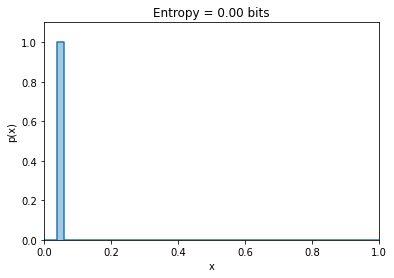

In [8]:
pmf = np.zeros(n_points)
pmf[2] = 1.0  # arbitrary point has all the mass

histogram(pmf, bins, ax_args={
  'title': f'Entropy = {entropy(pmf):.2f} bits',
  'xlabel': "x",
  'ylabel': "p(x)",
})

What about a distribution with mass split equally between two points?

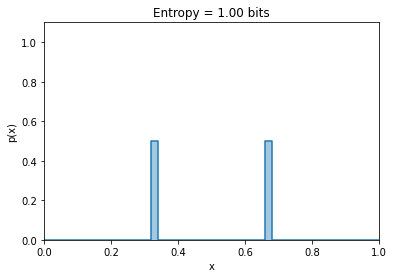

In [9]:
pmf = np.zeros(n_points)
pmf[len(pmf) // 3] = 0.5  
pmf[2 * len(pmf) // 3] = 0.5

histogram(pmf, bins, ax_args={
  'title': f'Entropy = {entropy(pmf):.2f} bits',
  'xlabel': "x",
  'ylabel': "p(x)",
  'ylim': [0, 1],
})

Here, the entropy calculation is

$-(0.5 \log_2 0.5 + 0.5\log_2 0.5)=1$

There is 1 bit of entropy. This means that before we take a random sample, there is 1 bit of uncertainty about which point in the distribution the sample will fall on: it will either be the first peak or the second one. 

Likewise, if we make one of the peaks taller (i.e. its point holds more of the probability mass) and the other one shorter, the entropy will decrease because of the increased certainty that the sample will fall on one point and not the other:



$-(0.2 \log_2 0.2 + 0.8\log_2 0.8)\approx 0.72$

Try changing the definition of the number and weighting of peaks, and see how the entropy varies.

If we split the probability mass among even more points, the entropy continues to increase. Let's derive the general form for $N$ points of equal mass, where $p_i=p=1/N$:

\begin{align}
 -\sum_i p_i \log_b p_i&= -\sum_i^N \frac{1}{N} \log_b \frac{1}{N}\\
                       &= -\log_b \frac{1}{N} \\
                       &= \log_b N
\end{align}
$$$$

If we have $N$ discrete points, the _uniform distribution_ (where points have equal mass) is the distribution with the highest entropy: $\log_b N$. This upper bound on entropy is useful when considering binning strategies, as any estimate of entropy over $N$ discrete points (or bins) must be in the interval $[0, \log_b N]$.


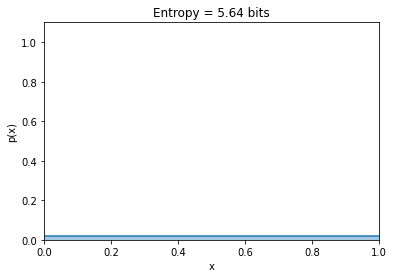

In [10]:
pmf = np.ones(n_points) / n_points  # [1/N] * N

histogram(pmf, bins, ax_args={
  'title': f'Entropy = {entropy(pmf):.2f} bits',
  'xlabel': "x",
  'ylabel': "p(x)",
  'ylim': [0, 1],
})

Here, there are 50 bins and the entropy of the uniform distribution is $\log_2 50\approx 5.64$. If we construct _any_ discrete distribution $X$ over 50 bins and calculate an entropy of $H_2(X)>\log_2 50$, something must be wrong with our implementation of the discrete entropy computation.

## Information, neurons, and spikes

Recall the discussion of spike times and inter-spike intervals (ISIs) from Tutorial 1. What does the information content (or distributional entropy) of these measures say about our theory of nervous systems? 

Let us consider three hypothetical neurons similar to those we explored in the Steinmetz data that all have the same mean ISIs but with different distributions:

1. Deterministic
2. Uniform
3. Exponential

How do we expect their entropies to differ?

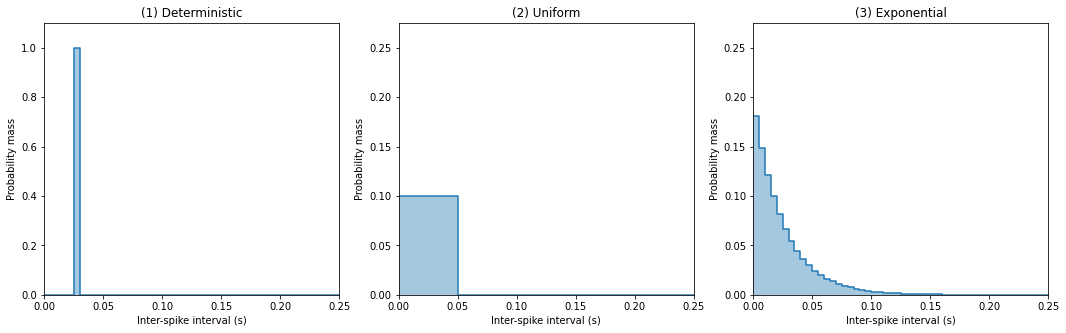

In [11]:
n_bins = 50
mean_isi = 0.025
bins = np.linspace(0, 0.25, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros_like(bins[1:])
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros_like(bins[1:])
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 5))
histogram(pmf_single, bins, ax=ax1, ax_args={
  'title': '(1) Deterministic',
  'xlabel': "Inter-spike interval (s)",
  'ylabel': "Probability mass",
  'ylim': [0, 1.0]
})
histogram(pmf_uniform, bins, ax=ax2, ax_args={
  'title': '(2) Uniform',
  'xlabel': "Inter-spike interval (s)",
  'ylabel': "Probability mass",
  'ylim': [0, 0.25]
})
histogram(pmf_exp, bins, ax=ax3, ax_args={
  'title': '(3) Exponential',
  'xlabel': "Inter-spike interval (s)",
  'ylabel': "Probability mass",
  'ylim': [0, 0.25]
})

In [12]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


In the previous example we created the PMFs by hand to illustrate idealized scenarios. How would we compute them from data recorded from actual neurons?

One way is to convert the ISI histograms we've previously computed and convert them into discrete probability distributions using the following equation:

\begin{align}
p(i) = \frac{n_i}{\sum\nolimits_{i}n_i}
\end{align}

where $p(i)$ is the probability of an ISI falling within a particular interval $i$ and $n_i$ is the count of how many ISIs were observed in that interval.

Video available at https://youtube.com/watch?v=hySy-J51vcI


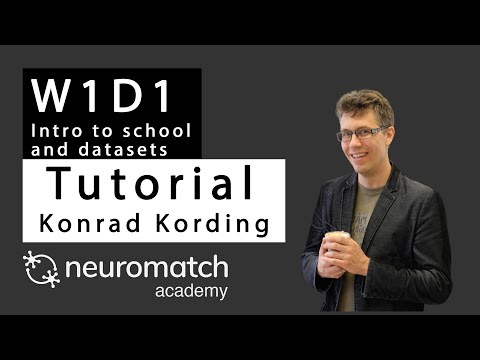

In [13]:
#@title Video: Entropy of different distributions
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='hySy-J51vcI', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise: Probabilty Mass Function

Your second exercise is to implement a method that will produce a probability mass function from an array of ISI bin counts.

To verify your solution, we will compute the probability distribution of ISIs from real neural data taken from the Steinmetz dataset.

In [14]:
neuron_idx = 283
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(0, 0.25, n_bins + 1)
counts, _ = np.histogram(isi, bins)

In [15]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  ###########################################################################
  ## TODO for students: compute the probability mass function from ISI counts 
  ###########################################################################
  raise NotImplementedError("Student excercise: compute the PMF from ISI counts")

# Uncomment once you complete the function
# pmf = pmf_from_counts(counts)
# histogram(pmf, bins, ax_args={
#   'title': f"Neuron {neuron_idx}",
#   'xlabel': "Inter-spike interval (s)",
#   'ylabel': "Probability mass",
# })

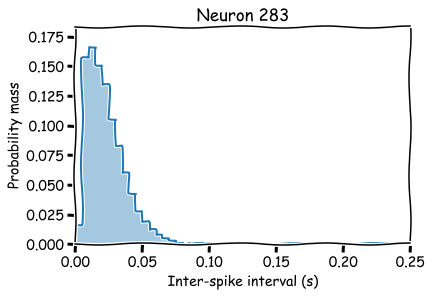

In [16]:
# to_remove solution
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf
pmf = pmf_from_counts(counts)
with plt.xkcd():
  histogram(pmf, bins, ax_args={
    'title': f"Neuron {neuron_idx}",
    'xlabel': "Inter-spike interval (s)",
    'ylabel': "Probability mass",
  })

Video available at https://youtube.com/watch?v=cyBu1pEGOh4


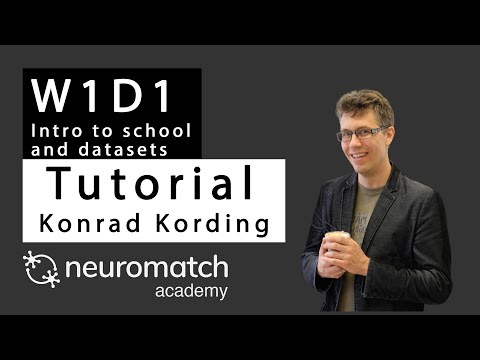

In [17]:
#@title Video: Calculating entropy of a probability distribution
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='cyBu1pEGOh4', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have the probability distribution for the actual neuron spiking activity, we can calculate its entropy.

In [18]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


### Data Exploration

We can combine the above distribution plot and entropy calculation with an interactive widget to explore how the different neurons in the dataset vary in spiking activity and relative information.

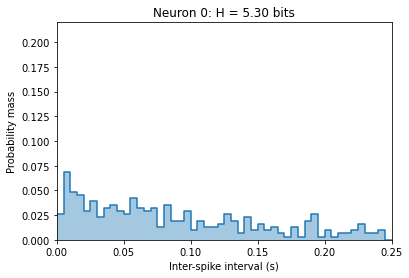

In [19]:
#@title Steinmetz Neuron Information Explorer

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf

def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)


@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(0, 0.25, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)
  
  ymax = max(0.2, np.max(pmf))
  histogram(pmf, bins, ax_args={
    'title': f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits",
    'xlabel': "Inter-spike interval (s)",
    'ylabel': "Probability mass",
    'ylim': [0, ymax]
  })

Video available at https://youtube.com/watch?v=-eGFd7E_smA


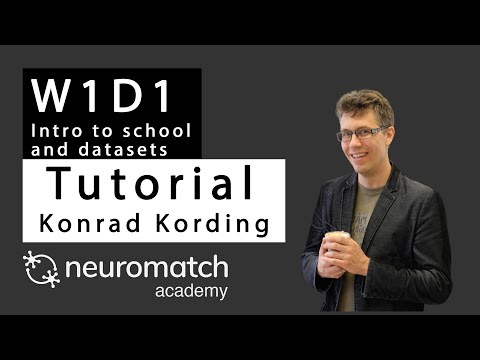

In [20]:
#@title Video: Summary of “why” models
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='-eGFd7E_smA', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

## Appendix

### The foundations for Entropy

**Shannon** [ref] began with three criteria for a function $H$ defining the entropy of a discrete distribution of probability masses $p_i\in p(X)$ over the points $x_i\in X$:
1. $H$ should be continuous in the $p_i$. 
  - That is, $H$ should change smoothly in response to smooth changes to the mass $p_i$ on each point $x_i$.
2. If all the points have equal shares of the probability mass, $p_i=1/N$, $H$ should be a non-decreasing function of $N$. 
  - That is, if $X_N$ is the support with $N$ discrete points and $p(x\in X_N)$ assigns constant mass to each point, then $H(X_1) < H(X_2) < H(X_3) < \dots$
3. $H$ should be preserved by (invariant to) the equivalent (de)composition of distributions.
  - For example [from Shannon's paper] if we have a discrete distribution over three points with masses $(\frac{1}{2},\frac{1}{3},\frac{1}{6})$, then their entropy can be represented in terms of a direct choice between the three and calculated $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})$. However, it could also be represented in terms of a series of two choices: 
    1. either we sample the point with mass $1/2$ or not (_not_ is the other $1/2$, whose subdivisions are not given in the first choice), 
    2. if (with probability $1/2$) we _don't_ sample the first point, we sample one of the two remaining points, masses $1/3$ and $1/6$.
    
    Thus in this case we require that $H(\frac{1}{2},\frac{1}{3},\frac{1}{6})=H(\frac{1}{2},\frac{1}{2}) + \frac{1}{2}H(\frac{1}{3}, \frac{1}{6})$

There is a unique function which satisfies these 3 requirements: [the function is unique up to scaling by a linear factor]

\begin{align}
  H_b(X) &= -\sum_{x\in X} p(x) \log_b p(x)
\end{align}

Where the base of the logarithm $b>1$ controls the units of entropy. The two most common cases are $b=2$ for units of _bits_, and $b=e$ for _nats_.

We can view this function as the expectation of the self-information over a distribution:

$$H_b(X) = \mathbb{E}_{x\in X} \left[I_b(x)\right]$$

$$I_b(x)=-\log_b p(x)$$

Self-information is just the negative logarithm of probability, and is a measure of how surprising an event sampled from the distribution would be. Events with $p(x)=1$ are certain to occur, and their self-information is zero [as is the entropy of the distribution they compose] meaning they are totally unsurprising. The smaller the probability of an event, the higher its self-information, and the more surprising the event would be to observe. 
